## Project Code

In [1]:
from __future__ import print_function
from distutils.version import LooseVersion as Version
import sys

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.7 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == min_ver:
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(sys.version)
if pyversion >= "3.7":
    print(OK, "Python version is %s" % sys.version)
elif pyversion < "3.7":
    print(FAIL, "Python version 3.7 is required,"
                " but %s is installed." % sys.version)
else:
    print(FAIL, "Unknown Python version: %s" % sys.version)

    
print()
requirements = {'numpy': "1.18.5", 'matplotlib': "3.2.2",'sklearn': "0.23.1", 
                'pandas': "1.0.5",'xgboost': "1.1.1", 'shap': "0.35.0"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 01:53:57) [MSC v.1916 64 bit (AMD64)]

[ OK ] numpy version 1.18.5 is installed.
[ OK ] matplotlib version 3.2.2 is installed.
[ OK ] sklearn version 0.23.1 is installed.
[ OK ] pandas version 1.0.5 is installed.
[ OK ] xgboost version 1.1.1 is installed.
[ OK ] shap version 0.35.0 is installed.


In [2]:
import numpy as np
import pandas as pd
import matplotlib
import math
from matplotlib import pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

## For a given national park, given a species of specific nativeness, order and family, can we predict abundance?

**Step 1**

Read data into the cell 

In [3]:
# read in the data in this cell
df1 = pd.read_csv('../data/species.csv', low_memory=False)
df1 = df1.loc[:, df1.columns != 'Unnamed: 13']
# print(df1)

In [4]:
df2 = pd.read_csv('../data/parks.csv')
# print(df2)

In [5]:
df = df1.merge(df2,how='outer',on='Park Name')  # merging on IDs present in any dataframe
df

,Species ID,Park Name,Category,Order,Family,Scientific Name,Common Names,Record Status,Occurrence,Nativeness,Abundance,Seasonality,Conservation Status,Park Code,State,Acres,Latitude,Longitude
0,ACAD-1000,Acadia National Park,Mammal,Artiodactyla,Cervidae,Alces alces,Moose,Approved,Present,Native,Rare,Resident,NaN,ACAD,ME,47390,44.35,-68.21
1,ACAD-1001,Acadia National Park,Mammal,Artiodactyla,Cervidae,Odocoileus virginianus,"Northern White-Tailed Deer, Virginia Deer, Whi...",Approved,Present,Native,Abundant,NaN,NaN,ACAD,ME,47390,44.35,-68.21
2,ACAD-1002,Acadia National Park,Mammal,Carnivora,Canidae,Canis latrans,"Coyote, Eastern Coyote",Approved,Present,Not Native,Common,NaN,Species of Concern,ACAD,ME,47390,44.35,-68.21
3,ACAD-1003,Acadia National Park,Mammal,Carnivora,Canidae,Canis lupus,"Eastern Timber Wolf, Gray Wolf, Timber Wolf",Approved,Not Confirmed,Native,NaN,NaN,Endangered,ACAD,ME,47390,44.35,-68.21
4,ACAD-1004,Acadia National Park,Mammal,Carnivora,Canidae,Vulpes vulpes,"Black Fox, Cross Fox, Eastern Red Fox, Fox, Re...",Approved,Present,Unknown,Common,Breeder,NaN,ACAD,ME,47390,44.35,-68.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119243,ZION-2791,Zion National Park,Vascular Plant,Solanales,Solanaceae,Solanum triflorum,Cut-Leaf Nightshade,Approved,Present,Native,Uncommon,NaN,NaN,ZION,UT,146598,37.30,-113.05
119244,ZION-2792,Zion National Park,Vascular Plant,Vitales,Vitaceae,Vitis arizonica,Canyon Grape,Approved,Present,Native,Uncommon,NaN,NaN,ZION,UT,146598,37.30,-113.05
119245,ZION-2793,Zion National Park,Vascular Plant,Vitales,Vitaceae,Vitis vinifera,Wine Grape,Approved,Present,Not Native,Uncommon,NaN,NaN,ZION,UT,146598,37.30,-113.05
119246,ZION-2794,Zion National Park,Vascular Plant,Zygophyllales,Zygophyllaceae,Larrea tridentata,Creosote Bush,Approved,Present,Native,Rare,NaN,NaN,ZION,UT,146598,37.30,-113.05


In [6]:
# df = df[(df['Record Status']!='Approved')]

df.shape

(119248, 18)

The following columns seem irrelevant to the model: 
1) Species ID



3) Common Names

4) Park Code


In [7]:
df = df.loc[:, df.columns != 'Species ID']
df = df.loc[:, df.columns != 'Common Names']
df = df.loc[:, df.columns != 'Park Code']
# df = df.loc[:, df.columns != 'State']
print(df.shape)

(119248, 15)


In [8]:
# df2 = df[(df['Category']!='Vascular Plant')]
# df2 = df2[(df2['Category']!='Nonvascular Plant')]

In [9]:
# df.dropna(subset=['Abundance'], inplace=True)                  Not dropping, converting to "Missing"
#for x in df['Abundance']:                              # iterates through each value in each column
#    if math.isnan(x)==True:             # if value is NaN and the column index for missing values has not been registered
#        print(i)
#        #col_missing = i
# values = {'Abundance': 'Missing'}      # value = values
df.fillna("Missing", inplace = True)

df.shape
df

,Park Name,Category,Order,Family,Scientific Name,Record Status,Occurrence,Nativeness,Abundance,Seasonality,Conservation Status,State,Acres,Latitude,Longitude
0,Acadia National Park,Mammal,Artiodactyla,Cervidae,Alces alces,Approved,Present,Native,Rare,Resident,Missing,ME,47390,44.35,-68.21
1,Acadia National Park,Mammal,Artiodactyla,Cervidae,Odocoileus virginianus,Approved,Present,Native,Abundant,Missing,Missing,ME,47390,44.35,-68.21
2,Acadia National Park,Mammal,Carnivora,Canidae,Canis latrans,Approved,Present,Not Native,Common,Missing,Species of Concern,ME,47390,44.35,-68.21
3,Acadia National Park,Mammal,Carnivora,Canidae,Canis lupus,Approved,Not Confirmed,Native,Missing,Missing,Endangered,ME,47390,44.35,-68.21
4,Acadia National Park,Mammal,Carnivora,Canidae,Vulpes vulpes,Approved,Present,Unknown,Common,Breeder,Missing,ME,47390,44.35,-68.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119243,Zion National Park,Vascular Plant,Solanales,Solanaceae,Solanum triflorum,Approved,Present,Native,Uncommon,Missing,Missing,UT,146598,37.30,-113.05
119244,Zion National Park,Vascular Plant,Vitales,Vitaceae,Vitis arizonica,Approved,Present,Native,Uncommon,Missing,Missing,UT,146598,37.30,-113.05
119245,Zion National Park,Vascular Plant,Vitales,Vitaceae,Vitis vinifera,Approved,Present,Not Native,Uncommon,Missing,Missing,UT,146598,37.30,-113.05
119246,Zion National Park,Vascular Plant,Zygophyllales,Zygophyllaceae,Larrea tridentata,Approved,Present,Native,Rare,Missing,Missing,UT,146598,37.30,-113.05


In [10]:
df2 = df[(df['Category']!='Vascular Plant')]
df2 = df2[(df2['Category']!='Nonvascular Plant')]
df2.shape

(49749, 15)

1) Relative abundance

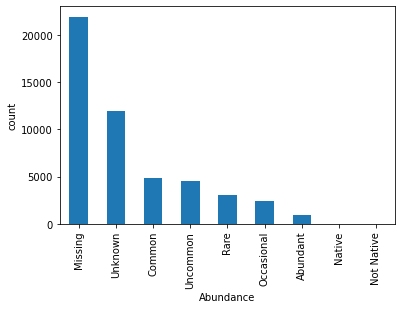

In [11]:
pd.value_counts(df2['Abundance']).plot.bar()
plt.ylabel('count')
plt.xlabel('Abundance')
plt.show()

In [12]:
# df = df[(df['Abundance']=="Uncommon")|(df['Abundance']=="Common")|(df['Abundance']=="Rare")|(df['Abundance']=="Occasional")|(df['Abundance']=="Abundant")]
# print(df.shape)
# print(df[(df['Category']=='Vascular Plant')].shape)
df2 = df2[(df2['Abundance']!='Native')]
df2 = df2[(df2['Abundance']!='Not Native')]
df2.shape
df = df2
df

,Park Name,Category,Order,Family,Scientific Name,Record Status,Occurrence,Nativeness,Abundance,Seasonality,Conservation Status,State,Acres,Latitude,Longitude
0,Acadia National Park,Mammal,Artiodactyla,Cervidae,Alces alces,Approved,Present,Native,Rare,Resident,Missing,ME,47390,44.35,-68.21
1,Acadia National Park,Mammal,Artiodactyla,Cervidae,Odocoileus virginianus,Approved,Present,Native,Abundant,Missing,Missing,ME,47390,44.35,-68.21
2,Acadia National Park,Mammal,Carnivora,Canidae,Canis latrans,Approved,Present,Not Native,Common,Missing,Species of Concern,ME,47390,44.35,-68.21
3,Acadia National Park,Mammal,Carnivora,Canidae,Canis lupus,Approved,Not Confirmed,Native,Missing,Missing,Endangered,ME,47390,44.35,-68.21
4,Acadia National Park,Mammal,Carnivora,Canidae,Vulpes vulpes,Approved,Present,Unknown,Common,Breeder,Missing,ME,47390,44.35,-68.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117880,Zion National Park,Fish,Salmoniformes,Salmonidae,Oncorhynchus clarkii utah,Approved,Present,Not Native,Occasional,Breeder,Missing,UT,146598,37.30,-113.05
117881,Zion National Park,Fish,Salmoniformes,Salmonidae,Oncorhynchus mykiss,Approved,Present,Not Native,Unknown,Breeder,Missing,UT,146598,37.30,-113.05
117882,Zion National Park,Fish,Salmoniformes,Salmonidae,Salmo trutta,Approved,Present,Not Native,Uncommon,Breeder,Missing,UT,146598,37.30,-113.05
117883,Zion National Park,Fish,Salmoniformes,Salmonidae,Salvelinus fontinalis,Approved,Present,Not Native,Occasional,Breeder,Missing,UT,146598,37.30,-113.05


In [13]:
print("Park Name: ", pd.unique(df2['Park Name']).shape[0])
print("Category: ", pd.unique(df2['Category']).shape[0])
print("Order: ", pd.unique(df2['Order']).shape[0])
print("Family: ", pd.unique(df2['Family']).shape[0])

Park Name:  56
Category:  12
Order:  412
Family:  1869


In [14]:
print("Scientific Names: ", pd.unique(df2['Scientific Name']).shape[0])

Scientific Names:  22676


In [15]:
df = df2

## Data Preprocessing

In [16]:
y = df2['Abundance'] 
X = df2.loc[:, df2.columns != 'Abundance'] # all other columns are features
z = df2['Park Name']

X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,stratify=z,random_state=42)   # first split
print('training set:',X_train.shape, y_train.shape)                           # 60% of points are in train
# z = X_train['Park Name']
# print(z.value_counts(normalize=True))

z_other = X_other['Park Name']
X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,stratify=z_other,random_state=42)  # second split
print('validation set:',X_val.shape, y_val.shape)                             # 20% of points are in validation
print('test set:',X_test.shape, y_test.shape)                                 # 20% of points are in test
# z_other = X_other['Park Name']
# print(z.value_counts(normalize=True))

# preprocess categorical variables - used OneHotEncoder
onehot_ftrs = ['Category', 'Order', 'Family', 'Scientific Name', 'Record Status', 'Occurrence', 'Nativeness', 'Seasonality', 'Conservation Status', 'State']                                                        # initialize the encoder
enc = OneHotEncoder(sparse=False,handle_unknown='ignore') 
enc.fit(X_train[onehot_ftrs])                                                 # fit the training data
print('   feature names:',enc.get_feature_names(onehot_ftrs).shape)
onehot_train = enc.transform(X_train[onehot_ftrs])                            # transform X_train
onehot_val = enc.transform(X_val[onehot_ftrs])                                # transform X_val
onehot_test = enc.transform(X_test[onehot_ftrs])                              # transform X_test
                       
# preprocess continuous variables - used StandardScaler
std_ftrs = ['Acres', 'Latitude', 'Longitude']
scaler = StandardScaler()
scaler_train = scaler.fit_transform(X_train[std_ftrs])                        # fit the training data, transform X_train
scaler_val = scaler.transform(X_val[std_ftrs])                                # transform X_val
scaler_test = scaler.transform(X_test[std_ftrs])                              # transform X_test
print('   ', scaler_test[100])
        
# preprocess Y - used LabelEncoder
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_val_le = le.transform(y_val)
y_test_le = le.transform(y_test)
print(y_test_le)
print(le.classes_)

training set: (29841, 14) (29841,)
validation set: (9947, 14) (9947,)
test set: (9947, 14) (9947,)
   feature names: (17596,)
    [-0.4665471  -0.08774252  1.48053129]
[4 5 1 ... 2 6 6]
['Abundant' 'Common' 'Missing' 'Occasional' 'Rare' 'Uncommon' 'Unknown']


## Evaluation Metrics

In [17]:
print(y.value_counts(normalize=True))

Missing       0.440676
Unknown       0.239610
Common        0.097316
Uncommon      0.091565
Rare          0.062592
Occasional    0.048839
Abundant      0.019403
Name: Abundance, dtype: float64


Thus it is not a very balanced dataset. So we opt for the f_beta score.

## ML Algorithms

In [18]:
train_scores = []
val_scores = []
test_scores = []
best_models = []

In [19]:
def MLpipe_stratsplit_f1(X,y,preprocessor,ML_algo,param_grid, i):
    '''
    This function splits the data to other/test (80/20) and then applies KFold with 4 folds to other.
    The RMSE is minimized in cross-validation.
    '''
    nr_states = 10
    
    X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,stratify=z,random_state=25*i)   # first split
    print('training set:',X_train.shape, y_train.shape)                           # 60% of points are in train
    # z = X_train['Park Name']
    # print(z.value_counts(normalize=True))

    z_other = X_other['Park Name']
    X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,stratify=z_other,random_state=25*i)  # second split
    print('validation set:',X_val.shape, y_val.shape)                             # 20% of points are in validation
    print('test set:',X_test.shape, y_test.shape)                                 # 20% of points are in test
    # z_other = X_other['Park Name']
    # print(z.value_counts(normalize=True))

    # preprocess categorical variables - used OneHotEncoder
    onehot_ftrs = ['Park Name', 'Category', 'Order', 'Family', 'Scientific Name', 'Record Status', 'Occurrence', 'Nativeness', 'Seasonality', 'Conservation Status', 'State']                                                        # initialize the encoder
      
    # preprocess continuous variables - used StandardScaler
    std_ftrs = ['Acres', 'Latitude', 'Longitude']

    # preprocess Y - used LabelEncoder
    le = LabelEncoder()
    y_train_le = le.fit_transform(y_train)
    y_val_le = le.transform(y_val)
    y_test_le = le.transform(y_test)
    #print(y_test_le)
    #print(le.classes_)
                
    # preprocess the data
        
    pipe = make_pipeline(preprocessor, ML_algo)
        
    # loop through the hyperparameter combinations or use GridSearchCV
        
    grid = GridSearchCV(pipe, param_grid=param_grid,scoring = "f1_weighted",
                    return_train_score = True, n_jobs=-1, verbose=True)
        
    # for each combination, calculate the train and validation scores using the evaluation metric
          
    # find which hyperparameter combination gives the best validation score (1 point)
    grid.fit(X_train, y_train_le)
    results = pd.DataFrame(grid.cv_results_)
    y_pred = grid.predict(X_train)
    train_score_ind = f1_score(y_train_le, y_pred, average = 'weighted')
    # print(results)
    
    # caclulate the validation score
    y_pred = grid.predict(X_val)
    val_score_ind = f1_score(y_val_le, y_pred, average = 'weighted')
     
    # calculate the test score 
    y_pred = grid.predict(X_test)
    test_score_ind = f1_score(y_test_le, y_pred, average = 'weighted')
     
    # append the test score and the best model to the lists (1 point)
    train_scores.append(train_score_ind)
    val_scores.append(val_score_ind)
    test_scores.append(test_score_ind)
    
    best_model_each = grid.best_estimator_
    best_models.append(grid.best_estimator_)

    return best_model_each, train_score_ind, val_score_ind, test_score_ind

In [20]:
y = df['Abundance'] 
X = df.loc[:, df.columns != 'Abundance'] # all other columns are features
z = df['Park Name']

# collect all the encoders
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftrs),
        ('std', StandardScaler(), std_ftrs)]) 
    
ML_algo = LogisticRegression(class_weight = 'balanced', solver = 'saga', random_state = 25)
param_grid = {'logisticregression__penalty': ['l1', 'l2'],
              'logisticregression__C': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]}

In [21]:
model_output, train_result, val_result, test_result = MLpipe_stratsplit_f1(X,y,preprocessor,ML_algo,param_grid, 1)

training set: (29841, 14) (29841,)
validation set: (9947, 14) (9947,)
test set: (9947, 14) (9947,)
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  5.2min finished


In [22]:
print(train_scores)
print(val_scores)
print(test_scores)
print(best_models)
#print("Mean of scores: ", np.mean(scores))
#print("Standard deviation of scores: ", np.std(scores))

[0.015207032358573137]
[0.015046579467045549]
[0.01615296968067867]
[Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Category', 'Order',
                                                   'Family', 'Scientific Name',
                                                   'Record Status',
                                                   'Occurrence', 'Nativeness',
                                                   'Seasonality',
                                                   'Conservation Status',
                                                   'State']),
                                                 ('std', StandardScaler(),
                                                  ['Acres', 'Latitude',
                 

In [23]:
model_output, train_result, val_result, test_result = MLpipe_stratsplit_f1(X,y,preprocessor,ML_algo,param_grid, 2)

training set: (29841, 14) (29841,)
validation set: (9947, 14) (9947,)
test set: (9947, 14) (9947,)
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  6.6min finished


In [24]:
print(train_scores)
print(val_scores)
print(test_scores)
print(best_models)

[0.015207032358573137, 0.015185593658574203]
[0.015046579467045549, 0.014982616423192653]
[0.01615296968067867, 0.016285486327582116]
[Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Category', 'Order',
                                                   'Family', 'Scientific Name',
                                                   'Record Status',
                                                   'Occurrence', 'Nativeness',
                                                   'Seasonality',
                                                   'Conservation Status',
                                                   'State']),
                                                 ('std', StandardScaler(),
                       

In [25]:
model_output, train_result, val_result, test_result = MLpipe_stratsplit_f1(X,y,preprocessor,ML_algo,param_grid, 3)

training set: (29841, 14) (29841,)
validation set: (9947, 14) (9947,)
test set: (9947, 14) (9947,)
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  8.2min finished


In [26]:
print(train_scores)
print(val_scores)
print(test_scores)
print(best_models)

[0.015207032358573137, 0.015185593658574203, 0.007413804948616095]
[0.015046579467045549, 0.014982616423192653, 0.00681857562482771]
[0.01615296968067867, 0.016285486327582116, 0.007826236822654641]
[Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Category', 'Order',
                                                   'Family', 'Scientific Name',
                                                   'Record Status',
                                                   'Occurrence', 'Nativeness',
                                                   'Seasonality',
                                                   'Conservation Status',
                                                   'State']),
                                 

In [27]:
model_output, train_result, val_result, test_result = MLpipe_stratsplit_f1(X,y,preprocessor,ML_algo,param_grid, 4)

training set: (29841, 14) (29841,)
validation set: (9947, 14) (9947,)
test set: (9947, 14) (9947,)
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  8.0min finished


In [28]:
print(train_scores)
print(val_scores)
print(test_scores)
print(best_models)

[0.015207032358573137, 0.015185593658574203, 0.007413804948616095, 0.004718072245263428]
[0.015046579467045549, 0.014982616423192653, 0.00681857562482771, 0.0042460254402094545]
[0.01615296968067867, 0.016285486327582116, 0.007826236822654641, 0.004352853273375565]
[Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Category', 'Order',
                                                   'Family', 'Scientific Name',
                                                   'Record Status',
                                                   'Occurrence', 'Nativeness',
                                                   'Seasonality',
                                                   'Conservation Status',
                            

In [29]:
model_output, train_result, val_result, test_result = MLpipe_stratsplit_f1(X,y,preprocessor,ML_algo,param_grid, 5)

training set: (29841, 14) (29841,)
validation set: (9947, 14) (9947,)
test set: (9947, 14) (9947,)
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  7.3min finished


In [30]:
print(train_scores)
print(val_scores)
print(test_scores)
print(best_models)

[0.015207032358573137, 0.015185593658574203, 0.007413804948616095, 0.004718072245263428, 0.27208628242437555]
[0.015046579467045549, 0.014982616423192653, 0.00681857562482771, 0.0042460254402094545, 0.26725824954450367]
[0.01615296968067867, 0.016285486327582116, 0.007826236822654641, 0.004352853273375565, 0.2644582212481984]
[Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Category', 'Order',
                                                   'Family', 'Scientific Name',
                                                   'Record Status',
                                                   'Occurrence', 'Nativeness',
                                                   'Seasonality',
                                        

In [31]:
model_output, train_result, val_result, test_result = MLpipe_stratsplit_f1(X,y,preprocessor,ML_algo,param_grid, 6)

training set: (29841, 14) (29841,)
validation set: (9947, 14) (9947,)
test set: (9947, 14) (9947,)
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 41.6min finished


In [32]:
print(train_scores)
print(val_scores)
print(test_scores)
print(best_models)

[0.015207032358573137, 0.015185593658574203, 0.007413804948616095, 0.004718072245263428, 0.27208628242437555, 0.0075759669201444415]
[0.015046579467045549, 0.014982616423192653, 0.00681857562482771, 0.0042460254402094545, 0.26725824954450367, 0.006232710108201724]
[0.01615296968067867, 0.016285486327582116, 0.007826236822654641, 0.004352853273375565, 0.2644582212481984, 0.007968689932052811]
[Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Category', 'Order',
                                                   'Family', 'Scientific Name',
                                                   'Record Status',
                                                   'Occurrence', 'Nativeness',
                                       

In [33]:
model_output, train_result, val_result, test_result = MLpipe_stratsplit_f1(X,y,preprocessor,ML_algo,param_grid, 7)

training set: (29841, 14) (29841,)
validation set: (9947, 14) (9947,)
test set: (9947, 14) (9947,)
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  8.0min finished


In [34]:
print(train_scores)
print(val_scores)
print(test_scores)
print(best_models)

[0.015207032358573137, 0.015185593658574203, 0.007413804948616095, 0.004718072245263428, 0.27208628242437555, 0.0075759669201444415, 0.0006962621945869621]
[0.015046579467045549, 0.014982616423192653, 0.00681857562482771, 0.0042460254402094545, 0.26725824954450367, 0.006232710108201724, 0.0008243077533665103]
[0.01615296968067867, 0.016285486327582116, 0.007826236822654641, 0.004352853273375565, 0.2644582212481984, 0.007968689932052811, 0.0007847822515115644]
[Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Category', 'Order',
                                                   'Family', 'Scientific Name',
                                                   'Record Status',
                                                 

In [35]:
model_output, train_result, val_result, test_result = MLpipe_stratsplit_f1(X,y,preprocessor,ML_algo,param_grid, 8)

training set: (29841, 14) (29841,)
validation set: (9947, 14) (9947,)
test set: (9947, 14) (9947,)
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  9.1min finished


In [36]:
print(train_scores)
print(val_scores)
print(test_scores)
print(best_models)

[0.015207032358573137, 0.015185593658574203, 0.007413804948616095, 0.004718072245263428, 0.27208628242437555, 0.0075759669201444415, 0.0006962621945869621, 0.004287419103255466]
[0.015046579467045549, 0.014982616423192653, 0.00681857562482771, 0.0042460254402094545, 0.26725824954450367, 0.006232710108201724, 0.0008243077533665103, 0.005390793214152408]
[0.01615296968067867, 0.016285486327582116, 0.007826236822654641, 0.004352853273375565, 0.2644582212481984, 0.007968689932052811, 0.0007847822515115644, 0.004533710413658649]
[Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Category', 'Order',
                                                   'Family', 'Scientific Name',
                                                   

In [37]:
model_output, train_result, val_result, test_result = MLpipe_stratsplit_f1(X,y,preprocessor,ML_algo,param_grid, 9)

training set: (29841, 14) (29841,)
validation set: (9947, 14) (9947,)
test set: (9947, 14) (9947,)
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  6.8min finished


In [38]:
print(train_scores)
print(val_scores)
print(test_scores)
print(best_models)

[0.015207032358573137, 0.015185593658574203, 0.007413804948616095, 0.004718072245263428, 0.27208628242437555, 0.0075759669201444415, 0.0006962621945869621, 0.004287419103255466, 0.007483101051741259]
[0.015046579467045549, 0.014982616423192653, 0.00681857562482771, 0.0042460254402094545, 0.26725824954450367, 0.006232710108201724, 0.0008243077533665103, 0.005390793214152408, 0.007200156664443878]
[0.01615296968067867, 0.016285486327582116, 0.007826236822654641, 0.004352853273375565, 0.2644582212481984, 0.007968689932052811, 0.0007847822515115644, 0.004533710413658649, 0.0072229069868846975]
[Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Category', 'Order',
                                                   'Family', 'Sc

In [39]:
model_output, train_result, val_result, test_result = MLpipe_stratsplit_f1(X,y,preprocessor,ML_algo,param_grid, 10)

training set: (29841, 14) (29841,)
validation set: (9947, 14) (9947,)
test set: (9947, 14) (9947,)
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  5.9min finished


In [40]:
print(train_scores)
print(val_scores)
print(test_scores)
print(best_models)

[0.015207032358573137, 0.015185593658574203, 0.007413804948616095, 0.004718072245263428, 0.27208628242437555, 0.0075759669201444415, 0.0006962621945869621, 0.004287419103255466, 0.007483101051741259, 0.0007135505342625902]
[0.015046579467045549, 0.014982616423192653, 0.00681857562482771, 0.0042460254402094545, 0.26725824954450367, 0.006232710108201724, 0.0008243077533665103, 0.005390793214152408, 0.007200156664443878, 0.0007692386366987938]
[0.01615296968067867, 0.016285486327582116, 0.007826236822654641, 0.004352853273375565, 0.2644582212481984, 0.007968689932052811, 0.0007847822515115644, 0.004533710413658649, 0.0072229069868846975, 0.0007847822515115644]
[Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Category', 'Ord

In [41]:
print("Mean of train scores: ", np.mean(train_scores), ", SD: ", np.std(train_scores))
print("Mean of validation scores: ", np.mean(val_scores), ", SD: ", np.std(val_scores))
print("Mean of test scores: ", np.mean(test_scores), ", SD: ", np.std(test_scores))

Mean of train scores:  0.033536708543939316 , SD:  0.07965907710703948
Mean of validation scores:  0.03287692528766424 , SD:  0.07826523534375546
Mean of test scores:  0.033037063918810866 , SD:  0.07730942010642272


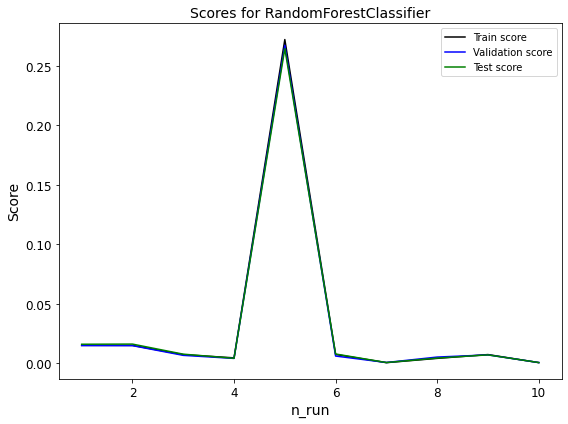

In [43]:
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
y = train_scores

plt.figure(figsize = (8, 6))
plt.plot(x, y, c = 'black', label = 'Train score')
#plt.errorbar(x, y, yerr = np.std(y), c = 'black')

y = val_scores
plt.plot(x, y, c = 'blue', label = 'Validation score')
#plt.errorbar(x, y, yerr = np.std(y), c = 'blue')

y = test_scores
plt.plot(x, y, c = 'green', label = 'Test score')
#plt.errorbar(x, y, yerr = np.std(y), c = 'green')

plt.xlabel('n_run', fontsize = 14)
plt.ylabel('Score', fontsize = 14)
# plt.semilogx()
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend()
plt.title('Scores for RandomForestClassifier', fontsize = 14)
plt.tight_layout()
# plt.savefig('figures/lasso_coefs.png',dpi=300)
plt.show()

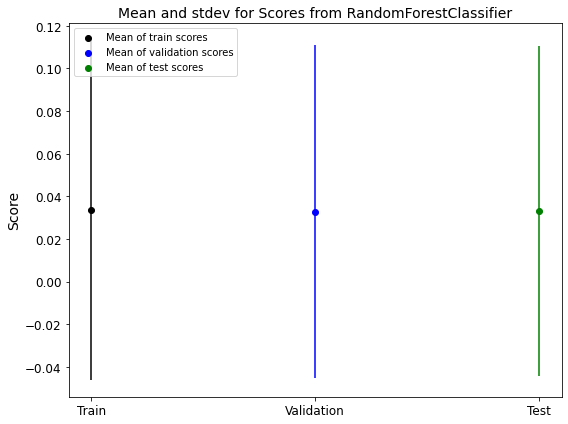

In [44]:
x = [1, 2, 3]
y = [np.mean(train_scores), np.mean(val_scores),np.mean(test_scores)]
yerr = [np.std(train_scores), np.std(val_scores), np.std(test_scores)],

plt.figure(figsize = (8, 6))
plt.scatter(1, np.mean(train_scores),  c = 'black', label = 'Mean of train scores')
plt.scatter(2, np.mean(val_scores),  c = 'blue', label = 'Mean of validation scores')
plt.scatter(3, np.mean(test_scores), c = 'green', label = 'Mean of test scores')
plt.errorbar(1, np.mean(train_scores), np.std(train_scores), c = 'black')
plt.errorbar(2, np.mean(val_scores), np.std(val_scores), c = 'blue')
plt.errorbar(3, np.mean(test_scores), np.std(test_scores), c = 'green')
#plt.errorbar(x, y, yerr = [np.std(train_scores), np.std(val_scores), np.std(test_scores)], c = 'black')

# y = val_scores
# plt.plot(x, y, c = 'blue', label = 'Validation score')
# #plt.errorbar(x, y, yerr = np.std(y), c = 'blue')

# y = test_scores
# plt.plot(x, y, c = 'green', label = 'Test score')
#plt.errorbar(x, y, yerr = np.std(y), c = 'green')

#plt.xlabel('n_run', fontsize = 14)
plt.ylabel('Score', fontsize = 14)
#plt.semilogx()
plt.xticks([1, 2, 3], ['Train', 'Validation', 'Test'], fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(loc = 'upper left')
plt.title('Mean and stdev for Scores from RandomForestClassifier', fontsize = 14)
plt.tight_layout()
plt.savefig('../figures/RFC_stratify_by_y.png',dpi=300)
#plt.show()